<a href="https://colab.research.google.com/github/KabuyaSamuel/Stock-Market-Prediction-ML-Model/blob/main/STOCK_MARKET_PREDICTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

STOCK MARKET PREDICTION

TEAM MATES
1. Samuel Kabuya
2. Felix Nabiswa
3. Jonathan Achira


Import the necessary libraries

STEP 1: IMPORT ALL THE NECESSARY LIBRARIES

In [332]:
# !pip install yfinance
# !pip install numpy
# !pip install pandas
# !pip install matplotlib
# !pip install tensorflow

import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.stattools import adfuller
from sklearn import svm
import joblib


STEP 2: LOAD THE DATASET

In [333]:
data = pd.read_csv('/content/CAC40_stocks_2021_2023.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Stock
0,2020-04-08,28.559999,28.559999,26.639999,28.270000,28.270000,1051666.0,AC.PA
1,2020-04-09,28.629999,29.570000,28.049999,28.639999,28.639999,990955.0,AC.PA
2,2020-04-14,28.010000,28.340000,27.150000,27.590000,27.590000,907178.0,AC.PA
3,2020-04-15,27.170000,27.299999,25.459999,25.660000,25.660000,1378290.0,AC.PA
4,2020-04-16,25.879999,26.700001,24.080000,24.570000,24.570000,1474307.0,AC.PA


In [334]:
# Specify the company and date range for prediction
company = 'ENGI.PA'
start_date = '2021-01-01'
end_date = '2023-01-01'

In [335]:
# Filter data for the specified company and date range
data = data[(data['Stock'] == company) & (data['Date'] >= start_date) & (data['Date'] <= end_date)]


STEP 3: PERFORM EXPLORATORY DATA ANALYSIS (EDA)

In [336]:
# Check the shape of the data
data.shape

(515, 8)

In [337]:
# Check the data types
data.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
Stock         object
dtype: object

In [338]:
# Check for missing values
data.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Stock        0
dtype: int64

In [339]:
# Summary statistics of the data
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,515.000000,515.000000,515.000000,515.000000,515.000000,5.150000e+02
mean,12.475371,12.605241,12.339138,12.474697,11.256134,5.911566e+06
std,0.895927,0.890304,0.912024,0.902817,1.250990,3.441658e+06
min,9.856000,10.410000,9.789000,10.100000,8.691945,7.729950e+05
25%,11.798000,11.887000,11.671000,11.775000,10.230058,4.202452e+06
50%,12.340000,12.432000,12.248000,12.330000,10.979389,5.234518e+06
75%,13.058000,13.167000,12.924500,13.065000,12.122000,6.706135e+06
max,14.632000,14.682000,14.488000,14.568000,14.520000,5.826393e+07


<Axes: xlabel='Close', ylabel='Count'>

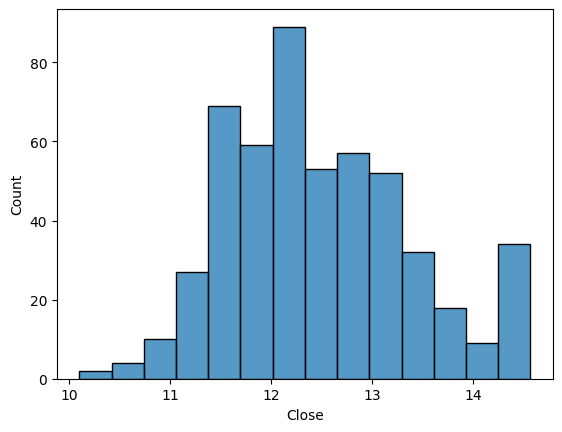

In [340]:
# Check the distribution of the target variable
sns.histplot(data['Close'])

In [341]:
# Drop non-numeric columns
numeric_data = data.drop(['Date', 'Stock'], axis=1)

# Calculate the correlation matrix
correlation_matrix = numeric_data.corr()

correlation_with_close = correlation_matrix['Close'].sort_values(ascending=False)

print(correlation_with_close)


Close        1.000000
Low          0.991868
High         0.990020
Open         0.980051
Adj Close    0.690203
Volume      -0.140288
Name: Close, dtype: float64


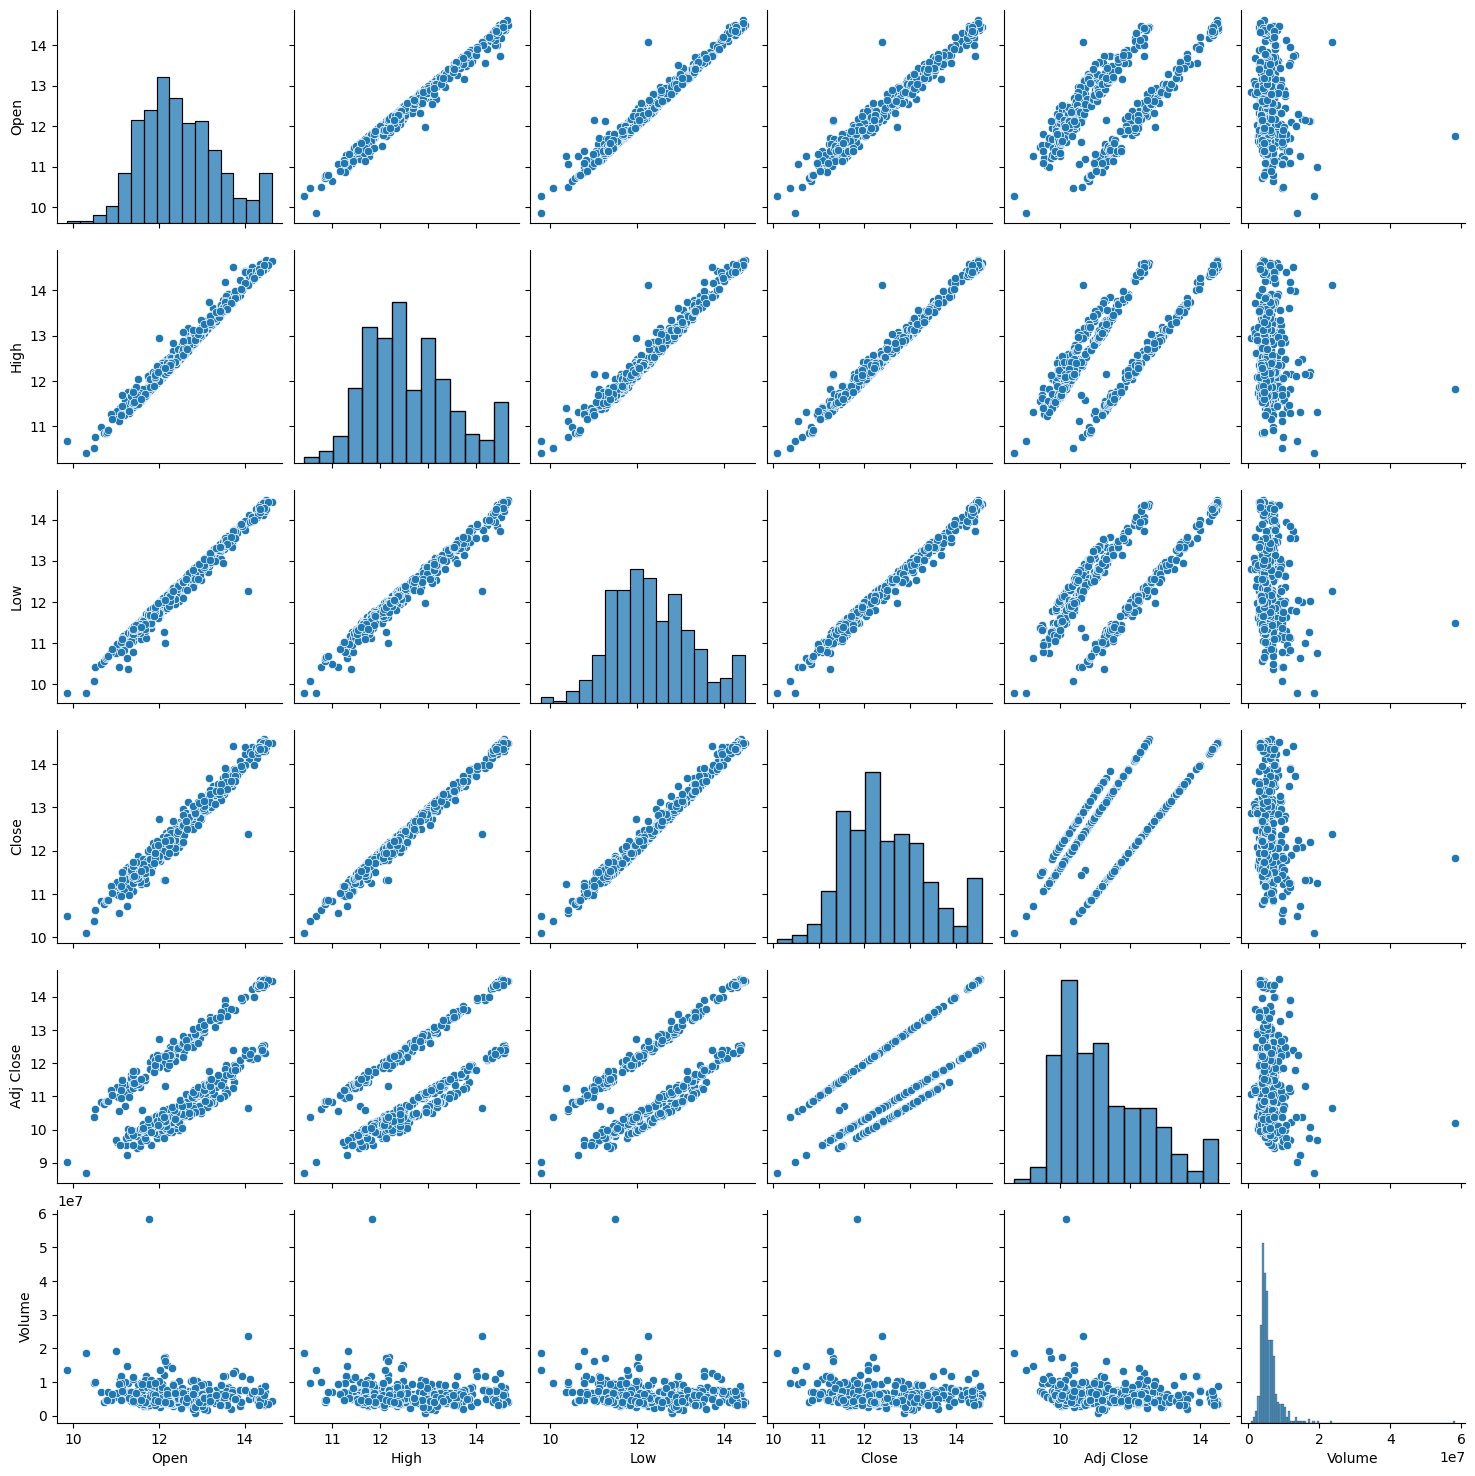

In [342]:
# Visualize the data
sns.pairplot(data)

STEP 4: DATA CLEANING

In [343]:
# Check for duplicates
duplicates = data.duplicated().sum()
print(f'Duplicates: {duplicates}')

Duplicates: 0


In [344]:
# Convert 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])


In [345]:
# Drop 'Adj Close' column
data = data.drop(columns=['Adj Close'])


STEP 4: NORMALIZE AND STANDARDIZE THE FEATURES

In [346]:
data.shape

(515, 7)

In [347]:
# Features for scaling
features = ['Open', 'High', 'Low', 'Volume']
target = 'Close'

# Extract features and target
X = data[features]
y = data[target]

scaler = MinMaxScaler()

# Fit and transform the features
X_scaled = scaler.fit_transform(X)

# Convert the scaled features back to a DataFrame for easier handling
X_scaled = pd.DataFrame(X_scaled, columns=features)

# Ensure the number of samples in X_scaled matches the original data
assert len(X_scaled) == len(y), f"X_scaled length: {len(X_scaled)}, y length: {len(y)}"

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)



In [348]:
data.dtypes

Date      datetime64[ns]
Open             float64
High             float64
Low              float64
Close            float64
Volume           float64
Stock             object
dtype: object

# STEP 5: SPLIT THE DATA INTO TRAINING AND TESTING SETS

In [349]:

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# STEP 6: BUILD AND TRAIN THE LSTM MODEL

In [350]:

# Define the model
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

model.add(Dense(units=1))

model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
history = model.fit(X_train, y_train, epochs=500, batch_size=32)




Epoch 1/500
13/13 [==============================] - 4s 8ms/step - loss: 152.9832
Epoch 2/500
13/13 [==============================] - 0s 8ms/step - loss: 141.0237
Epoch 3/500
13/13 [==============================] - 0s 8ms/step - loss: 101.3086
Epoch 4/500
13/13 [==============================] - 0s 8ms/step - loss: 30.5396
Epoch 5/500
13/13 [==============================] - 0s 8ms/step - loss: 3.7210
Epoch 6/500
13/13 [==============================] - 0s 8ms/step - loss: 1.5587
Epoch 7/500
13/13 [==============================] - 0s 10ms/step - loss: 1.6952
Epoch 8/500
13/13 [==============================] - 0s 8ms/step - loss: 1.4415
Epoch 9/500
13/13 [==============================] - 0s 10ms/step - loss: 1.6526
Epoch 10/500
13/13 [==============================] - 0s 11ms/step - loss: 1.3273
Epoch 11/500
13/13 [==============================] - 0s 8ms/step - loss: 1.3008
Epoch 12/500
13/13 [==============================] - 0s 8ms/step - loss: 1.4230
Epoch 13/500
13/13 [=======

1/1 [==============================] - 0s 22ms/step


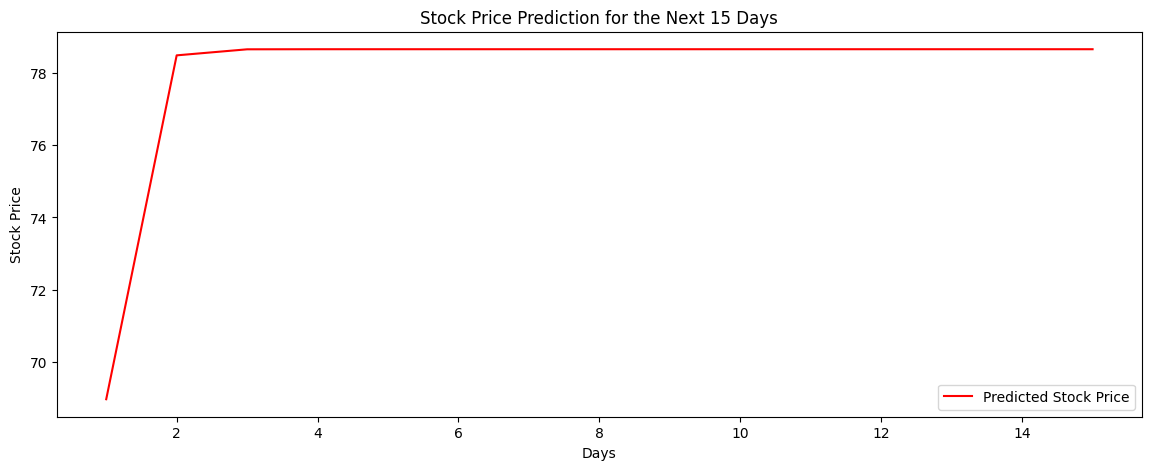

In [351]:
# Number of days to predict
days_to_predict = 15

predictions = []

# Copy X_scaled to another variable for prediction purposes
X_scaled_for_prediction = X_scaled.copy()

# Generate predictions for the next days_to_predict days
for _ in range(days_to_predict):
    # Predict the next day
    next_pred = model.predict(X_scaled_for_prediction[-1:].values)
    predictions.append(next_pred.flatten()[0])

    # Prepare the next input
    next_input = np.append(X_scaled_for_prediction.iloc[-1, :-1].values, next_pred.flatten())
    next_input = next_input.reshape(1, -1)

    # Append the new input to X_scaled_for_prediction
    X_scaled_for_prediction = np.append(X_scaled_for_prediction.values, next_input, axis=0)
    X_scaled_for_prediction = pd.DataFrame(X_scaled_for_prediction, columns=features)

# Convert the predictions back to the original scale

target_scaler = MinMaxScaler()
y_scaled = target_scaler.fit_transform(y.values.reshape(-1, 1))
predictions = np.array(predictions).reshape(-1, 1)
predictions = target_scaler.inverse_transform(predictions)

# Plot the results
plt.figure(figsize=(14, 5))
plt.plot(range(1, days_to_predict + 1), predictions, color='red', label='Predicted Stock Price')
plt.title(f'Stock Price Prediction for the Next {days_to_predict} Days')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [352]:
# Evaluate the model on the testing set
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)

mae = mean_absolute_error(y_test, y_pred)

r_squared = r2_score(y_test, y_pred)


# Print Metrics
print(f"R-squared: {r_squared:.2f}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")


4/4 [==============================] - 1s 5ms/step - loss: 0.0723
Test Loss: 0.07228746265172958
4/4 [==============================] - 1s 4ms/step
R-squared: 0.90
Mean Squared Error: 0.07
Mean Absolute Error: 0.25


4/4 [==============================] - 0s 5ms/step


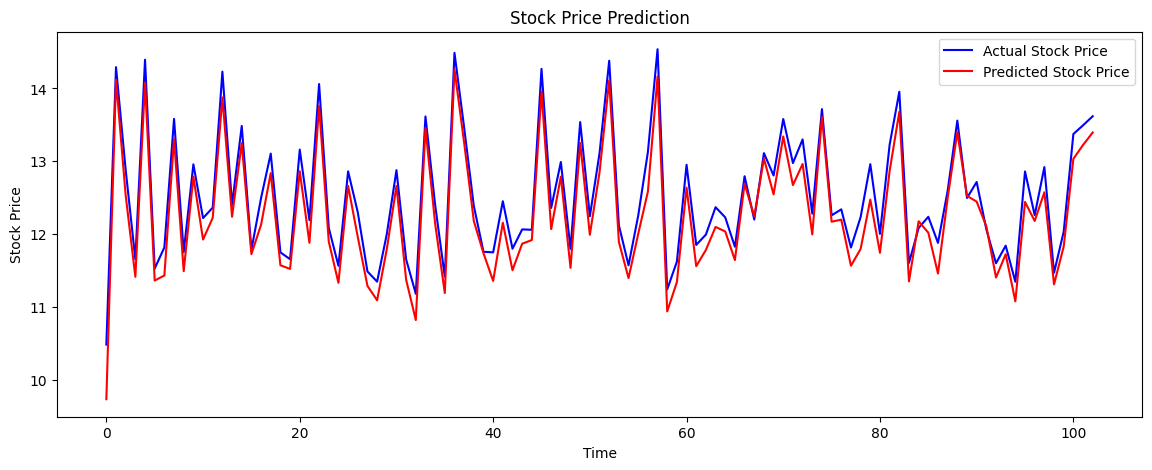

In [353]:
# Make predictions
predictions = model.predict(X_test)

# Convert predictions and actual values back to the original scale
predictions = predictions.flatten()
predictions = y_test.index.to_frame().assign(Close=predictions).set_index('Close', drop=True).index

# Plot the results
plt.figure(figsize=(14,5))
plt.plot(y_test.values, color='blue', label='Actual Stock Price')
plt.plot(predictions, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [354]:
# Save the model
joblib.dump(model_fit, 'LSTM_model.pkl')

['LSTM_model.pkl']

#CREATE SECOND MODEL USING ARIMA ARCHITECTURE

##STEPS TAKEN

In [355]:
# Perform ADF test to check for stationarity
result = adfuller(y)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# If the series is not stationary, difference the data
if result[1] > 0.05:
    y_diff = y.diff().dropna()
else:
    y_diff = y

ADF Statistic: -3.404983234037719
p-value: 0.010790162010261834


#Define the ARIMA Model

In [356]:

# Define the ARIMA model
p = 1  # AR order
d = 1  # differencing order
q = 1  # MA order

model = ARIMA(y_diff, order=(p, d, q))
model_fit = model.fit()

# Print the model summary
print(model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  515
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  95.181
Date:                Sat, 15 Jun 2024   AIC                           -184.361
Time:                        09:40:16   BIC                           -171.635
Sample:                             0   HQIC                          -179.373
                                - 515                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6549      0.136      4.815      0.000       0.388       0.921
ma.L1         -0.5606      0.158     -3.541      0.000      -0.871      -0.250
sigma2         0.0404      0.001     48.298      0.0

##MAKE PREDICTIONS

In [357]:
# Forecasting the future values
days_to_predict = 15
forecast = model_fit.forecast(steps=days_to_predict)

# Prepare for evaluation
y_train, y_test = y_diff[:-days_to_predict], y_diff[-days_to_predict:]

# Make predictions on the testing set
y_pred = model_fit.predict(start=len(y_train), end=len(y_train)+len(y_test)-1)

# Convert predictions back to the original scale if differenced
if result[1] > 0.05:
    forecast = np.cumsum(forecast) + y.iloc[-1]

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


##EVALUATE THE PERFOMANCE

In [360]:
# Calculate accuracy metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)

# Print Metrics

print(f"R-squared: {r_squared:.2f}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")

R-squared: 0.73
Mean Squared Error: 0.03
Mean Absolute Error: 0.14


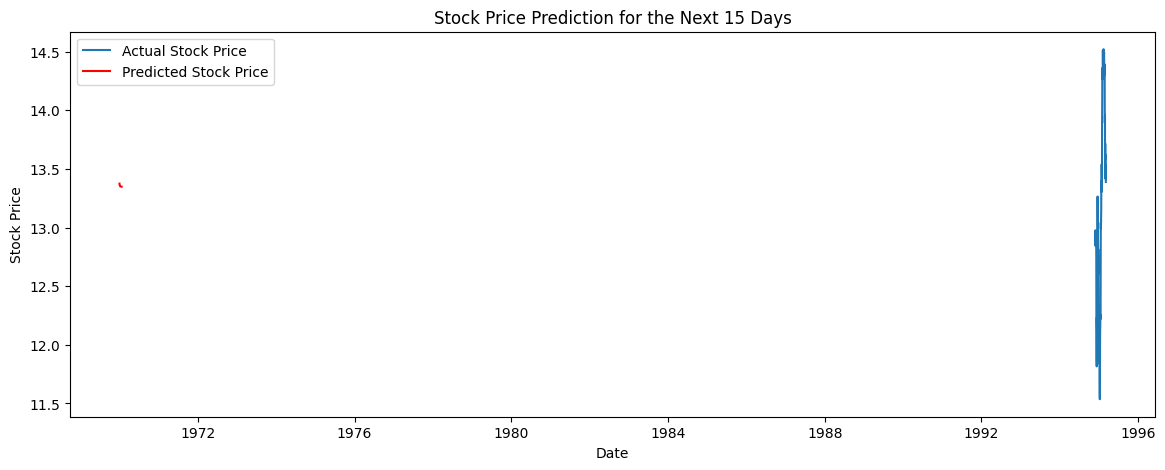

In [361]:

# Plot the results
plt.figure(figsize=(14, 5))
plt.plot(y.index[-100:], y.values[-100:], label='Actual Stock Price')
plt.plot(pd.date_range(y.index[-1], periods=days_to_predict, freq='B'), forecast, color='red', label='Predicted Stock Price')
plt.title(f'Stock Price Prediction for the Next {days_to_predict} Days')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [362]:
# Save the model
joblib.dump(model_fit, 'arima_model.pkl')

['arima_model.pkl']

#MODEL 3: SVM (SUPPORT VECTOR MACHINES)

DEFINE AND RETRAIN THE MODEL

In [363]:
# # Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create an SVM model
model = svm.SVR()

# Train the model
model.fit(X_train, y_train)


SVR()

## EVALUATE THE MODEL

In [367]:
# Evaluate the model on the testing set
test_loss = model.score(X_test, y_test)
print(f'Test Loss: {test_loss}')

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)

mae = mean_absolute_error(y_test, y_pred)

r_squared = r2_score(y_test, y_pred)


# Print Metrics
print(f"R-squared: {r_squared:.2f}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")

Test Loss: 0.9899883243131756
R-squared: 0.99
Mean Squared Error: 0.01
Mean Absolute Error: 0.06


##Make Predictions

In [365]:
# Make predictions on the testing set
y_pred = model.predict(X_test)

# Make predictions
predictions = model.predict(X_test)

# Convert predictions and actual values back to the original scale
predictions = predictions.flatten()
predictions = y_test.index.to_frame().assign(Close=predictions).set_index('Close', drop=True).index

##Visualize the results

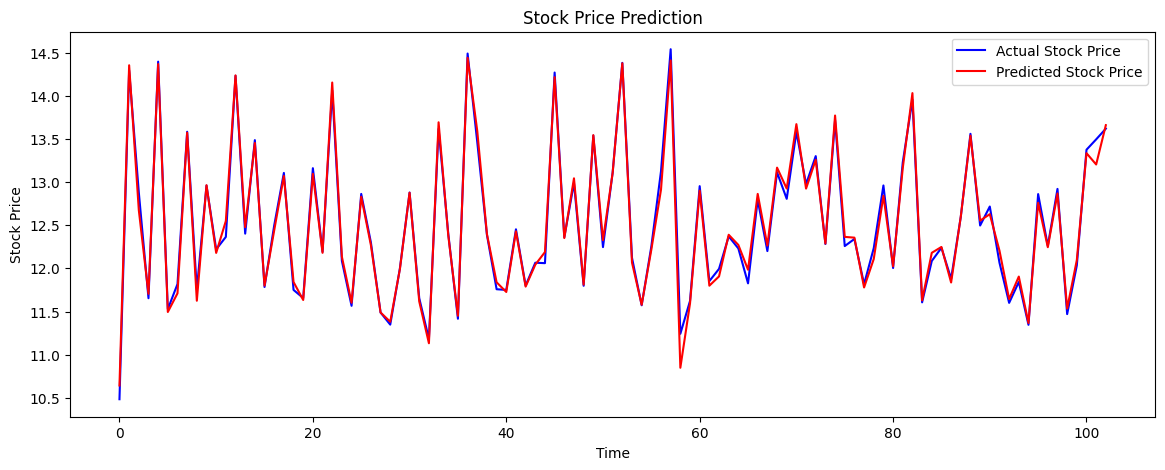

In [366]:

# Plot the results
plt.figure(figsize=(14,5))
plt.plot(y_test.values, color='blue', label='Actual Stock Price')
plt.plot(predictions, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [368]:
# Save the model
joblib.dump(model_fit, 'SVM_model.pkl')

['SVM_model.pkl']